In [1]:
import json
import random
import numpy as np
import torch
from torch import nn
import pandas as pd
import plotly.express as px
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import sklearn.metrics as skmetrics

In [2]:
class Vocab:
    def __init__(self, tokens): 
        special_tokens = ["PAD", "SOS", "EOS"]
        self.tokens = tokens + special_tokens
        self.token_ix = {t:i for i, t in enumerate(self.tokens)}
        self.ix_token = {i:t for i,t in enumerate(self.tokens)}

    def encode(self, seq, max_len=None):
        encoded = [self.token_ix["SOS"]] + [self.token_ix[t] for t in seq] + [self.token_ix["EOS"]]
        if max_len:
            if len(encoded) < max_len:
                encoded += [self.token_ix["PAD"]]*(max_len-len(encoded))
                
        return encoded
                
    def decode(self, seq):
        return [self.ix_token[t] for t in seq]

class ProteinVocab(Vocab):
    def __init__(self):
        # 20 amino acids
        tokens = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y']
        super().__init__(tokens)
        
class SMILEVocab(Vocab):
    def __init__(self):
        tokens = ['#','(',')','+','-','.','/','1','2','3','4','5','6','7','8','=','@',
                  'A','B','C','F','G','H','I','K','L','M','N','O','P','S','T','V','W','Z',
                  '[','\\',']','a','b','d','e','g','i','l','n','o','r','s','t','u']
        super().__init__(tokens)

In [3]:
ut_id_to_seq = json.load(open("../data/uniprotid_to_seq.json", 'r'))
db_id_to_smile = json.load(open("../data/databankid_to_smile.json", 'r'))

In [4]:
protein_vocab = ProteinVocab()
smile_vocab = SMILEVocab()

In [5]:
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1, dropout=0, bidirectional=False):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.bidirectional = bidirectional
        
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True, bidirectional=bidirectional)
        self.out = nn.Linear(hidden_size*2 if self.bidirectional else hidden_size, vocab_size)
        
        
    def forward(self, x, hidden=None):
        x = self.embedding(x)
        x, hidden = self.gru(x, hidden)
        x = self.out(x[:, -1])
        return x, hidden

In [6]:
smile_model = GRUModel(
    vocab_size=len(smile_vocab.tokens),
    embed_size=64,
    hidden_size=128,
    num_layers=1,
    dropout=0,
    bidirectional=False
)

protein_model = GRUModel(
    vocab_size=len(protein_vocab.tokens),
    embed_size=64,
    hidden_size=128,
    num_layers=1,
    dropout=0,
    bidirectional=False
)

In [7]:
smile_checkpoint = torch.load("../checkpoints/pretraining/smile_gru.pth")
protein_checkpoint = torch.load("../checkpoints/pretraining/protein_gru.pth")

In [8]:
smile_model.load_state_dict(smile_checkpoint)
protein_model.load_state_dict(protein_checkpoint)

<All keys matched successfully>

In [9]:
del ut_id_to_seq["Gene"]
del db_id_to_smile["#Drug"]

In [10]:
smile_embeddings = smile_model.embedding
amino_embeddings = protein_model.embedding

In [11]:
dataset = {
    "x": [], # contains {"drug": DRUG, "target": "target"} 
    "y": [], # contains [0 or 1]
}

In [12]:
df = pd.read_csv("../data/ChG-Miner_miner-chem-gene.tsv", sep="\t")

In [13]:
random.choice(df[df["#Drug"]!="DB00357"]["Gene"].values)

'P16471'

In [14]:
for i in tqdm(range(len(df))):
    row = df.iloc[i]
    
    positive_x = {
        "drug": None,
        "target": None
    }
    
    negative_x_1 = {
        "drug": None,
        "target": None
    }
    
    negative_x_2 = {
        "drug": None,
        "target": None
    }
    
    labels = [1, 0]
    
    positive_x["drug"] = row["#Drug"]
    positive_x["target"] = row["Gene"]
    
    negative_x_1["drug"] = row["#Drug"]
    negative_x_1["target"] = random.choice(df[df["#Drug"]!=row["#Drug"]]["Gene"].values)
    
    dataset["x"].append(positive_x)
    dataset["x"].append(negative_x_1)
    
    dataset["y"]+=labels

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 15138/15138 [01:16<00:00, 198.17it/s]


(array([15138.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 15138.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

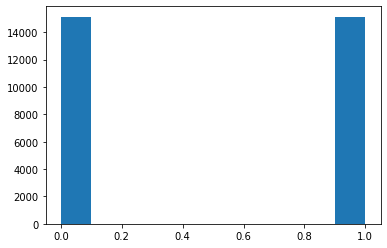

In [15]:
import matplotlib.pyplot as plt

plt.hist(dataset["y"])


In [16]:
dataset

{'x': [{'drug': 'DB00357', 'target': 'P05108'},
  {'drug': 'DB00357', 'target': 'P52209'},
  {'drug': 'DB02721', 'target': 'P00325'},
  {'drug': 'DB02721', 'target': 'Q9GZZ6'},
  {'drug': 'DB00773', 'target': 'P23219'},
  {'drug': 'DB00773', 'target': 'P04798'},
  {'drug': 'DB07138', 'target': 'Q16539'},
  {'drug': 'DB07138', 'target': 'O14949'},
  {'drug': 'DB08136', 'target': 'P24941'},
  {'drug': 'DB08136', 'target': 'P10635'},
  {'drug': 'DB01242', 'target': 'P23975'},
  {'drug': 'DB01242', 'target': 'P11509'},
  {'drug': 'DB01238', 'target': 'P08173'},
  {'drug': 'DB01238', 'target': 'P31350'},
  {'drug': 'DB00186', 'target': 'P48169'},
  {'drug': 'DB00186', 'target': 'Q15858'},
  {'drug': 'DB00338', 'target': 'P10635'},
  {'drug': 'DB00338', 'target': 'P08514'},
  {'drug': 'DB01151', 'target': 'P08913'},
  {'drug': 'DB01151', 'target': 'P10275'},
  {'drug': 'DB01244', 'target': 'P05023'},
  {'drug': 'DB01244', 'target': 'P28845'},
  {'drug': 'DB01745', 'target': 'P07477'},
  {'dr

In [17]:
    np.random.seed(42)

indices = np.arange(len(dataset["y"]))

In [18]:
np.random.shuffle(indices)

In [19]:
train_pct = .8

In [20]:
train_indices = indices[:int(train_pct * len(indices))]
test_indices = indices[int(train_pct * len(indices)):]

In [95]:
train_indices.shape, test_indices.shape

((24220,), (6056,))

In [22]:
train_x = np.array(dataset["x"])[train_indices]
train_y = np.array(dataset["y"])[train_indices]

test_x = np.array(dataset["x"])[test_indices]
test_y = np.array(dataset["y"])[test_indices]

In [98]:
json.dump(train_x.tolist(), open("../data/dti_train_x.json", "w"))
json.dump(train_y.tolist(), open("../data/dti_train_y.json", "w"))

json.dump(test_x.tolist(), open("../data/dti_test_x.json", "w"))
json.dump(test_y.tolist(), open("../data/dti_test_y.json", "w"))


In [23]:
sum(test_y)/len(test_y)

0.49653236459709377

In [30]:
class DTIDataset(Dataset):
    def __init__(self, data):
        self.x, self.y = data
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        row = self.x[idx]
        
        drug = row["drug"]
        target = row["target"]
        
        drug = db_id_to_smile[drug]
        drug = torch.Tensor(smile_vocab.encode(drug)).unsqueeze(0).long() # get tokenized
        drug = smile_embeddings(drug).mean(1).squeeze() # get embeddings
        
        target = ut_id_to_seq[target]
        target = torch.Tensor(protein_vocab.encode(target)).unsqueeze(0).long() # get tokenized
        target = amino_embeddings(target).mean(1).squeeze() # get embeddings
        
        y = self.y[idx].tolist()
        
        return drug, target, y

In [31]:
train = DTIDataset(data=(train_x, train_y))
test = DTIDataset(data=(test_x, test_y))

In [32]:
train = DataLoader(train, batch_size=128, shuffle=True)
test = DataLoader(test, batch_size=128, shuffle=True)

In [34]:
class DTINet(nn.Module):
    def __init__(self, embed_size, project_size=16, dropout=0):
        super().__init__()
        self.attn1 = nn.MultiheadAttention(
            embed_dim=64, 
            num_heads=1,
            dropout=dropout,
        )
        
        self.attn2 = nn.MultiheadAttention(
            embed_dim=64, 
            num_heads=1,
            dropout=dropout,
        )
        
        self.drug_project = nn.Linear(embed_size, project_size)
        self.protein_project = nn.Linear(embed_size, project_size)
        
#         self.out = nn.Sequential(
#             nn.Linear(embed_size, embed_size),
#             nn.ReLU(),
#             nn.Linear(embed_size, 2)
#         )   

    def forward(self, drug_embed, protein_embed, return_weights=False):
#         print(drug_embed.shape, protein_embed.shape)
        batch_size, embed_size = drug_embed.shape[:2]

#         drug_embed = drug_embed.view(batch_size, embed_size, 1)
#         protein_embed = protein_embed.view(batch_size, embed_size, 1)

        drug_proj = self.drug_project(drug_embed)
        prot_proj = self.protein_project(protein_embed)
        
        return drug_proj, prot_proj
        
#         aligned_drug, drug_attention_weights = self.attn1(
#             query=protein_embed,
#             value=drug_embed,
#             key=drug_embed,
#             need_weights=return_weights
#         )

#         aligned_protein, protein_attention_weights = self.attn2(
#             query=drug_embed,
#             value=protein_embed,
#             key=protein_embed,
#             need_weights=return_weights
#         )
# 
#         aligned = (aligned_drug + aligned_protein).view(batch_size, -1)

#         out = self.out(aligned)

#         if return_weights:
#             return out, drug_attention_weights, protein_attention_weights

#         return out

In [35]:
net = DTINet(embed_size=64, project_size=16, dropout=0)

In [93]:
class ContrastiveLoss(nn.Module):
    def __init__(self, phi=1):
        super().__init__()
        self.phi = phi
        self.bce = nn.BCEWithLogitsLoss()
        
    def forward(self, first, second, labels):
        # first -> (N, E)
        # second -> (N, E)
        
        distance = nn.functional.pairwise_distance(first, second)
        
        loss = (1-labels) * (distance**2) + labels * torch.clamp(self.phi - distance, min=0)**2
        
        loss = loss.mean()
        
        return loss

In [94]:
num_epochs = 100
lr = 3e-3
lossfn = ContrastiveLoss()

from torch import optim

train_loss_over_time = []
test_loss_over_time = []

train_accuracy_over_time = []
test_accuracy_over_time = []

train_f1_over_time = []
test_f1_over_time = []

optimizer = optim.Adam(net.parameters(), lr=lr)

for epoch in range(num_epochs):
    train_loss_epoch = []
    test_loss_epoch = []
    
    train_accuracy_epoch = []
    test_accuracy_epoch = []
    
    train_f1_epoch = []
    test_f1_epoch = []
    
    for x1, x2, y in tqdm(train):
        optimizer.zero_grad()
        y = y.long()
        
        p1, p2 = net(x1, x2)
        loss = lossfn(p1, p2 , y)
        
        loss.backward()
        
        optimizer.step()
        
        train_loss_epoch.append(loss.item())
#         accuracy = (p.argmax(-1) == y).sum()/p.shape[0]
        
#         f1_score = skmetrics.f1_score(y, p.argmax(-1))
        
#         train_accuracy_epoch.append(accuracy.item())
        
#         train_f1_epoch.append(f1_score)
        
    with torch.no_grad():
        for x1, x2, y in tqdm(test):
            y = y.long()
        
            p1, p2 = net(x1, x2)
            loss = lossfn(p1, p2, y)
            test_loss_epoch.append(loss.item())
#             accuracy = (p.argmax(-1) == y).sum()/p.shape[0]
            
#             f1_score = skmetrics.f1_score(y, p.argmax(-1))
            
#             test_accuracy_epoch.append(accuracy.item())
            
#             test_f1_epoch.append(f1_score)
            
    train_loss_epoch = sum(train_loss_epoch)/len(train_loss_epoch)
    test_loss_epoch = sum(test_loss_epoch)/len(test_loss_epoch)
    
#     train_accuracy_epoch = sum(train_accuracy_epoch)/len(train_accuracy_epoch)
#     test_accuracy_epoch = sum(test_accuracy_epoch)/len(test_accuracy_epoch)
    
#     train_f1_epoch = sum(train_f1_epoch)/len(train_f1_epoch)
#     test_f1_epoch = sum(test_f1_epoch)/len(test_f1_epoch)
    
    train_loss_over_time.append(train_loss_epoch)

#     train_accuracy_over_time.append(train_accuracy_epoch)
    
    test_loss_over_time.append(test_loss_epoch)
    
#     test_accuracy_over_time.append(test_accuracy_epoch)
    
#     train_f1_over_time.append(train_f1_epoch)
#     test_f1_over_time.append(test_f1_epoch)
    
    print(f"Epoch : {epoch+1} | Test Loss : {test_loss_epoch:.4f} | Train Loss : {train_loss_epoch:.4f}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 10.06it/s]


Epoch : 1 | Test Loss : 0.2498 | Train Loss : 0.2554


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 10.01it/s]


Epoch : 2 | Test Loss : 0.2515 | Train Loss : 0.2515


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 11.35it/s]


Epoch : 3 | Test Loss : 0.2605 | Train Loss : 0.2503


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 11.67it/s]


Epoch : 4 | Test Loss : 0.2604 | Train Loss : 0.2515


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 10.72it/s]


Epoch : 5 | Test Loss : 0.2782 | Train Loss : 0.2515


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 10.60it/s]


Epoch : 6 | Test Loss : 0.2467 | Train Loss : 0.2495


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 11.96it/s]


Epoch : 7 | Test Loss : 0.2693 | Train Loss : 0.2522


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 11.61it/s]


Epoch : 8 | Test Loss : 0.2470 | Train Loss : 0.2498


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 11.62it/s]


Epoch : 9 | Test Loss : 0.2448 | Train Loss : 0.2493


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 11.35it/s]


Epoch : 10 | Test Loss : 0.2699 | Train Loss : 0.2499


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 10.77it/s]


Epoch : 11 | Test Loss : 0.2460 | Train Loss : 0.2475


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:03<00:00, 12.45it/s]


Epoch : 12 | Test Loss : 0.2457 | Train Loss : 0.2484


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:03<00:00, 15.40it/s]


Epoch : 13 | Test Loss : 0.2502 | Train Loss : 0.2469


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 19.58it/s]


Epoch : 14 | Test Loss : 0.2461 | Train Loss : 0.2490


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 18.93it/s]


Epoch : 15 | Test Loss : 0.2510 | Train Loss : 0.2488


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:03<00:00, 13.45it/s]


Epoch : 16 | Test Loss : 0.2460 | Train Loss : 0.2476


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 16.06it/s]


Epoch : 17 | Test Loss : 0.2492 | Train Loss : 0.2469


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 19.85it/s]


Epoch : 18 | Test Loss : 0.2511 | Train Loss : 0.2479


 16%|█████████████████▏                                                                                           | 30/190 [00:09<00:48,  3.30it/s]


KeyboardInterrupt: 